(b) (10 points)
• Implement in PyTorch this network and loss (using torch tensors and functionalize, but not nn.module).
• Validate with test cases the gradients computed by PyTorch match those of
your answer in (a). To do this, generate random {x, y} samples with components from either uniform or Gaussian distribution.
• Show the difference between the corresponding matrices (gradient calculated
by hand, and gradient from torch.autograd) using torch.linalg.norm.

In [6]:
import torch
import numpy as np
def my_nn(input, param_dict):
    input_value = input
    for l in [1,2]:
      if l == 1:
          layer_weight = param_dict["W"+str(l)]
          layer_bias = param_dict["b"+str(l)]
          layer_input = torch.mm(layer_weight, input_value).add(layer_bias)
          layer_output = torch.sigmoid(layer_input)
          input_value = layer_output
      if l == 2:
          layer_weight = param_dict["W"+str(l)]
          layer_bias = param_dict["b"+str(l)]
          layer_input = torch.mm(layer_weight.T, input_value).add(layer_bias)
          layer_output = layer_input
    return layer_output
def compare_gradients():
    param_dict = {
        'W1' : torch.rand(20,10,requires_grad = True),
        'W2' : torch.rand(20,1, requires_grad = True),
        'b1' : torch.zeros(20, 1, requires_grad = True),
        'b2' : torch.zeros(1, 1, requires_grad=True)
    }
    random_data = torch.rand(10,1)
    random_target = torch.rand(1,1)
    output = my_nn(random_data, param_dict)
    curr_loss = torch.mean(torch.abs(output-random_target))
    curr_loss.backward()
    w1 = param_dict['W1']
    w2 = param_dict['W2']
    b1 = param_dict['b1']
    b2 = param_dict['b2']
    x = random_data
    y_pred = output
    y = random_target
    g_W1_torch = w1.grad
    g_W2_torch = w2.grad
    g_b1_torch = b1.grad
    g_b2_torch = b2.grad
    z1 = torch.mm(w1, x).add(b1)
    x1 = torch.sigmoid(z1)
    g_W1 = torch.mm((torch.sign(y_pred-y)*w2) * (torch.sigmoid(z1)*(1-torch.sigmoid(z1))), x.T)
    g_W2 = torch.sign(y_pred-y) * x1
    g_b1 = (torch.sign(y_pred-y)*w2) * (torch.sigmoid(z1)*(1-torch.sigmoid(z1)))
    g_b2 = torch.sign(y_pred-y) * 1
    diff_w1 = torch.linalg.norm(g_W1)- torch.linalg.norm(g_W1_torch)
    diff_w2 = torch.linalg.norm(g_W2)-torch.linalg.norm(g_W2_torch)
    diff_b1 = torch.linalg.norm(g_b1)-torch.linalg.norm(g_b1_torch)
    diff_b2 = torch.linalg.norm(g_b2)-torch.linalg.norm(g_b2_torch)
    assert diff_w1 < 1e-4
    assert diff_w2 < 1e-4
    assert diff_b1 < 1e-4
    assert diff_b2 < 1e-4
    print('W1', diff_w1)
    print('W2', diff_w2)
    print('b1', diff_b1)
    print('b2', diff_b2)

for i in range(5):
    compare_gradients()





W1 tensor(0., grad_fn=<SubBackward0>)
W2 tensor(0., grad_fn=<SubBackward0>)
b1 tensor(0., grad_fn=<SubBackward0>)
b2 tensor(0., grad_fn=<SubBackward0>)
W1 tensor(0., grad_fn=<SubBackward0>)
W2 tensor(0., grad_fn=<SubBackward0>)
b1 tensor(0., grad_fn=<SubBackward0>)
b2 tensor(0., grad_fn=<SubBackward0>)
W1 tensor(0., grad_fn=<SubBackward0>)
W2 tensor(0., grad_fn=<SubBackward0>)
b1 tensor(-1.4901e-08, grad_fn=<SubBackward0>)
b2 tensor(0., grad_fn=<SubBackward0>)
W1 tensor(0., grad_fn=<SubBackward0>)
W2 tensor(0., grad_fn=<SubBackward0>)
b1 tensor(0., grad_fn=<SubBackward0>)
b2 tensor(0., grad_fn=<SubBackward0>)
W1 tensor(0., grad_fn=<SubBackward0>)
W2 tensor(0., grad_fn=<SubBackward0>)
b1 tensor(-2.9802e-08, grad_fn=<SubBackward0>)
b2 tensor(0., grad_fn=<SubBackward0>)


(c) (10 point) Train this model on the sklearn California Housing Prices datasets.

In [91]:
import torch
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
class California_Dataset(Dataset):
    def __init__(self, house_data, house_targets):
        self.house_labels = house_targets
        self.house_data = house_data
    def __len__(self):
        return len(self.house_labels)
    def __getitem__(self, idx):
        return self.house_data[idx], self.house_labels[idx]

california_data, california_target = sklearn.datasets.fetch_california_housing(data_home=None, download_if_missing=True, return_X_y=True, as_frame=False)
print(california_data.shape)
print(california_target.shape)

#Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(california_data, california_target,test_size=0.50)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train,test_size=0.20) # create validation set

california_dataset = California_Dataset(X_train, y_train)
california_dataset2 = California_Dataset(X_test, y_test)
california_dataset3 = California_Dataset(X_val, y_val)
train_dataloader = torch.utils.data.DataLoader(california_dataset,
                                           batch_size=8,
                                           shuffle=True,
                                           drop_last=True)
test_dataloader = torch.utils.data.DataLoader(california_dataset2,
                                              batch_size=8,
                                              shuffle=True,
                                              drop_last=True)
val_dataloader = torch.utils.data.DataLoader(california_dataset3, batch_size=8, shuffle=True,
                                             drop_last=True)
param_dict = {
    'W1' : torch.rand(20,8,requires_grad = True), # 8,20
    'W2' : torch.rand(20,1, requires_grad = True), # 20,1
    'b1' : torch.zeros(20,1 , requires_grad = True), # 20,1
    'b2' : torch.zeros(1,8, requires_grad=True) # 1,8
}
learning_rates = [0.01,0.05, 0.1, 0.25]
mse_models = []
for l in learning_rates:
    mse_val = []
    for key, value in param_dict.items():
        if key[0] == 'W':
          param_dict[key] = (torch.sqrt(torch.tensor([1])/value.shape[0]) * torch.randn(value.shape[0],value.shape[1])).requires_grad_()
        if key[0] == 'b':
          param_dict[key].requires_grad_()
    parameter_list = param_dict.values()
    optimizer = torch.optim.SGD(parameter_list, lr=l)
    for data_val, target_val in val_dataloader:
       optimizer.zero_grad()
       output_val = my_nn(data_val.float(), param_dict)
       curr_loss = torch.mean(torch.abs(output_val-target_val)) # should we use MSE or absolute error here?
       curr_loss.backward()
       curr_mse = torch.mean(torch.square(output_val-target_val))
       #print(target_val.shape)
       mse_val.append(curr_mse.detach())
       optimizer.step()
    mse_models.append(torch.mean(torch.tensor(mse_val)))
print(mse_models)
best_lr = learning_rates[torch.argmax(torch.tensor(mse_models))]
print(best_lr)
for key, value in param_dict.items():
    if key[0] == 'W':
      param_dict[key] = (torch.sqrt(torch.tensor([1])/value.shape[0]) * torch.randn(value.shape[0],value.shape[1])).requires_grad_()
    if key[0] == 'b':
      param_dict[key].requires_grad_()
parameter_list = param_dict.values()
optimizer = torch.optim.SGD(parameter_list, lr=best_lr)

train_losses = []
test_losses = []
for epoch in range(50):
  print(epoch)
  epoch_losses_train = []
  epoch_losses_test = []
  for (data, target) in train_dataloader:
      optimizer.zero_grad()
      output = my_nn(data.float(), param_dict)
      curr_loss = torch.mean(torch.abs(output-target)) # should we use MSE or absolute error here?
      #curr_loss = torch.mean(torch.square(output-target))
      mse_train = torch.mean(torch.square(output-target))
      epoch_losses_train.append(mse_train.detach())
      curr_loss.backward()
      #mse_train = (output==target).sum()/target.shape[0]
      #print(mse_train)
      optimizer.step()
  for (data_test, target_test) in test_dataloader:
      output_test = my_nn(data_test.float(), param_dict)
      #output = torch.mean(output, dim=1)
      mse_test = torch.mean(torch.square(output_test-target_test))
      epoch_losses_test.append(mse_test.detach())

# how do I report MSE on whole test and whole train set in each epoch?
  train_losses.append(torch.mean(torch.tensor(epoch_losses_train)))
  test_losses.append(torch.mean(torch.tensor(epoch_losses_test)))
#print(train_losses)
#print(test_losses)
plt.subplot(1, 2, 1)
plt.plot(test_losses)
plt.title("Test mse ")
plt.subplot(1, 2, 2)
plt.plot(train_losses)
plt.title("Train mse ")
plt.show()

KeyboardInterrupt: 

2(a) (15 points) Consider the neural network
f(x) = WF ρ ◦ WL . . . ρ ◦ Wi
. . . ρ ◦ W2ρ ◦ W1x
where W1 is K ×D, Wi
is K ×K for i > 1, and WF is P ×K. Note f : RD → RP
Take ρ(x) = tanh(x).
Consider the case D = 2, K = 30, P = 10 use torch tensors to write a function
which computes the Jacobian, ∂f(x)
∂x , using backward mode automatic differentiation
for a given value of x and W1, . . . , Wi
, . . . , WF where the given matrices are specified
by a dictionary of torch tensors. Specifically your function should be able to take
different values for L. Implement and test this for L = 3. Your function should
only make use of basic matrix operations (e.g. torch.matmul(), torch.tanh(), etc).

In [331]:
from torch.autograd.functional import jacobian
import torch
import time
for i in range(2, 1000):
    param_dict['W' + str(i)] = torch.rand(30,30, requires_grad=True)
param_dict['WF'] = torch.randn(10, 30, requires_grad=True)
param_dict['W1'] = torch.randn(30,2,requires_grad = True)
w1 = param_dict['W1']
w2 = param_dict['W2']
w3 = param_dict['W3']
wf = param_dict['WF']
w4 = param_dict['W4']
w5 = param_dict['W5']


def backward_tanh(curr_input):
    return 1-torch.square(torch.tanh(curr_input))

def backward_autodiff(params, x, l):
    save_forward = []
    curr_input = x
    wf = params['WF']
    # forward pass
    for i in range(1, l+1):
        curr_w = params['W'+ str(i)]
        curr_input = torch.matmul(curr_w, curr_input)
        save_forward.append(curr_input) # save result for jacobian calculation
        curr_input = torch.tanh(curr_input)
    output = torch.matmul(wf, curr_input) # output of forward pass
    weight_list = [] # list with all the weights between 1 and l
    for i in range(2, l+1):
        weight_list.append(params['W'+ str(i)])
    curr_jac = wf*(backward_tanh(save_forward[-1]))
    save_forward.pop() # last saved element is not needed anymore
    save_forward.reverse()
    for index, w in enumerate(reversed(weight_list)):
        curr_jac = torch.matmul(curr_jac, w*backward_tanh(save_forward[index])) # calculate jacobian
    curr_jac = torch.matmul(curr_jac, params['W1'])
    #print(curr_jac)
    return curr_jac

def forward_autodiff(params, x, l):
    curr_input = x
    wf = params['WF']
    # forward pass
    curr_jac = w1.T
    for i in range(1, l+1):
        curr_w = params['W'+ str(i)]
        curr_input = torch.matmul(curr_w, curr_input)
        if i+1 <= l:
            #print(str(i+1))
            curr_jac = torch.matmul(curr_jac, (backward_tanh(curr_input)*params['W'+ str(i+1)]).T)
        else:
            curr_jac = torch.matmul(curr_jac, (backward_tanh(curr_input)*wf).T).T
        curr_input = torch.tanh(curr_input)
    #print(curr_jac)
    return curr_jac



    #return curr_jac

def backward_tanh(x):
    return (1-torch.square(torch.tanh(x)))
def forward3(x):
    out_layer1 = torch.matmul(w1, x)
    out_layertanh1 = torch.tanh(out_layer1)
    out_layer2 = torch.matmul(w2, out_layertanh1)
    out_layertanh2 = torch.tanh(out_layer2)
    out_layer3 = torch.matmul(w3, out_layertanh2)
    out_layertanh3 = torch.tanh(out_layer3)
    out_final = torch.matmul(wf, out_layertanh3)
    return out_final


#Printing the Jacobian
inputs = torch.randn((2,), requires_grad = True)
for i in [880, 900, 905, 940]:
    start = time.time()
    forward_autodiff(param_dict, inputs, i)
    end = time.time()
    print(end-start, 'forward')
    start = time.time()
    backward_autodiff(param_dict, inputs, i)
    end = time.time()
    print(end-start, 'backward')
# for i in [800, 990]:
#     start = time.time()
#     forward_autodiff(param_dict, inputs.cuda(), i)
#     end = time.time()
#     print(end-start, 'forward')
#     start = time.time()
#     backward_autodiff(param_dict, inputs.cuda(), i)
#     end = time.time()
#     print(end-start, 'backward')
    #print(torch.linalg.norm(jacobian_by_hand2(param_dict, inputs, i))- torch.linalg.norm(jacobian_by_hand(param_dict, inputs, i)))
#print(jacobian_by_hand(param_dict, inputs, 1))
#forward3(inputs)
#print(jacobian(forward3, inputs))
#print(jacobian_by_hand2(param_dict, inputs, 1))



0.14134716987609863 forward
0.10899567604064941 backward
0.24135923385620117 forward
0.11220288276672363 backward
0.09699678421020508 forward
0.12023258209228516 backward
0.08199739456176758 forward
0.0689997673034668 backward


(b) (Extra Credit +5 points) Implement a function using torch tensors and forward
mode automatic differentiation to compute ∂f(x)
∂x . Validate (with assert statements)
for several test cases that your answer matches the function (b) for L = 3. Hint:
You must calculate the derivatives and the network’s output in the same forward
pass (unlike backward differentiation where you need two loops, one for the forward
pass and one for calculating the gradient).

(c) (5 points) Benchmark the Jacobian computation of (a) for L=3,5,10. Report
speed of these answers on test cases using GPU and CPU.

(d) (5 points) Assume matrix multiply operations between sizes M1×M2 and M2×M3
result in M1 ∗M2 ∗M3 ops. Briefly discuss the theoretical speed comparisons of (a)
backward and (b) forward mode differentiation. Note the actual implementation
of (b) is extra credit.

4. (a) (5 points) We will study different ways to initialize models. First create a nn.module
with a variable that defines the number of feedforward layers, while taking MNIST
digits as inputs. The module should allow constructing a network as follows:
net = my model(depth).
It may be helpful to use the nn.ModuleList construction. For the rest of the
exercise we will use a width of 50 hidden units. The input layer of your network
should take minibatches of data sized B × 784 where B is the batch size and the
output should have 10 values. For this network use a tanh non-linearity.

In [12]:
from torch import nn
from math import sqrt
import torch
# class LinearNet(nn.Module):
#   def __init__(self, input_size, num_layers, layers_size, output_size):
#      self.num_layer = num_layers
#      super(LinearNet, self).__init__()
#      self.linears = nn.ModuleList([nn.Linear(input_size, layers_size)])
#      self.linears.extend([nn.Linear(layers_size, layers_size) for i in range(1, self.num_layers-1)])
#      self.linears.append(nn.Linear(layers_size, output_size))
# linear_net = LinearNet(64, 5, 200, 10)
class Model(nn.Module):
    def __init__(self, depth, d):
        self.depth = depth
        super(Model,self).__init__()
        self.layers = nn.ModuleList([nn.Linear(784,50)])
        self.layers.extend([nn.Linear(50, 50) for i in range(1, self.depth-1)])
        self.layers.append(nn.Linear(50, 10))
        if d == 'Xavier':
            for name, param in self.named_parameters():
                if name.endswith('weight'):
                   torch.nn.init.uniform_(param.data, a= -sqrt(6/(param.data.shape[0] + param.data.shape[1])),b = sqrt(6/(param.data.shape[0] + param.data.shape[1])))
                else:
                    torch.nn.init.zeros_(param.data)
        else:
            for name, param in self.named_parameters():
                if name.endswith('weight'):
                    torch.nn.init.uniform_(param.data, a=-d, b=d)
                    #print(name, param.data)
                else:
                    torch.nn.init.zeros_(param.data)
                    #print('bias', name, param.data)
    def forward(self, X_batch):
        X_batch = X_batch.view(-1 , 28*28)
        for idx, layer in enumerate(self.layers):
            if idx == 0:
                layer_out = torch.tanh(layer(X_batch))
                layer_out.retain_grad()
            else:
                layer_out = torch.tanh(layer(layer_out))
                layer_out.retain_grad()
        return layer_out
model = Model(50, 0.01)

(b) (2 points) Write a function to initialize your model w ∼ U(−d, d) and biases to
zero. We will study the 4 cases d = 0.01, 0.1, 2.0,
q 6
ni+no
. Note the final value
corresponds to Xavier initialization with ni
, no the number of input and output
connections to a unit. You will perform part (c) and (d) for all 4 values of d and
depth 8. This function can be a member of the your model class. You may make
use of the built in torch.nn.init functions to achieve this.

layers.0.weight tensor([[ 0.0091, -0.0024, -0.0091,  ..., -0.0008, -0.0027, -0.0022],
        [ 0.0073,  0.0018, -0.0094,  ..., -0.0004,  0.0055,  0.0066],
        [-0.0092, -0.0022,  0.0045,  ...,  0.0058, -0.0064, -0.0079],
        ...,
        [ 0.0007,  0.0044,  0.0018,  ..., -0.0058, -0.0069,  0.0054],
        [-0.0087, -0.0027,  0.0071,  ...,  0.0059, -0.0070, -0.0020],
        [ 0.0092, -0.0072, -0.0036,  ...,  0.0061,  0.0028, -0.0010]])
bias layers.0.bias tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.,

(c) (8 points) Using a cross-entropy loss at the end of the network: forward and
backward a minibatch of 256 MNIST digits through the network with depth 8.
Compute and visualize the gradient norm at each layer. Specifically this refers to
the ∂L ∂a, where a are the post-activation outputs. Your plots should have layer on
the x-axis and gradient norm on the y-axis. Note that to get the gradient norms
at each layer you can use retain grad on the layer outputs in the forward pass to
keep the gradient buffer from clearing at each layer on the backward. Perform this
for each of the 4 initializations to obtain 4 curves. Note: in this question you do
not need to train or update the models.


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


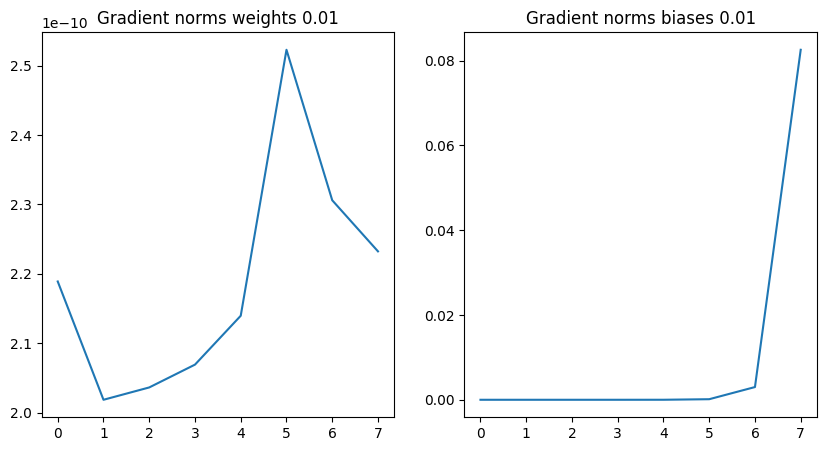

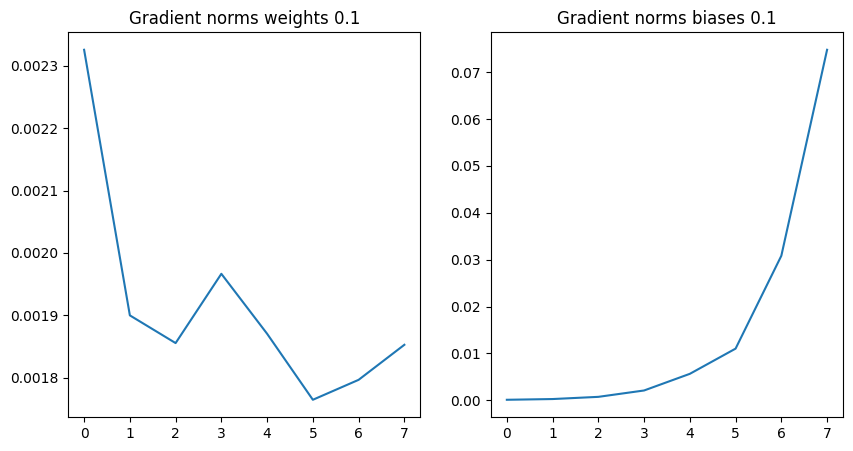

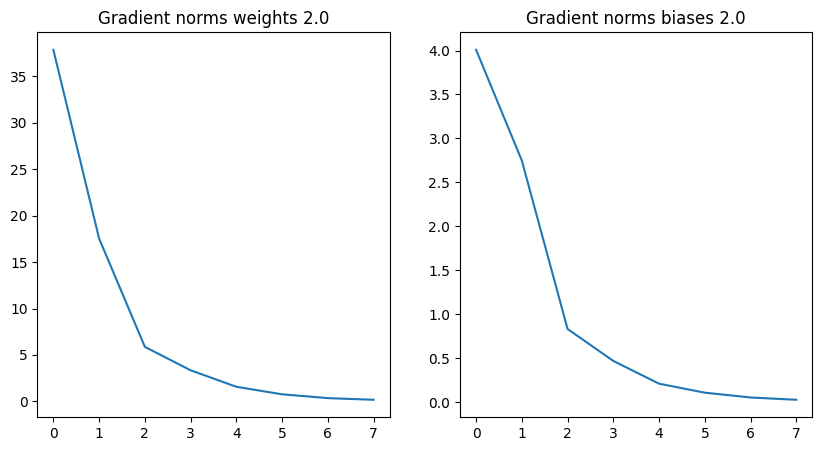

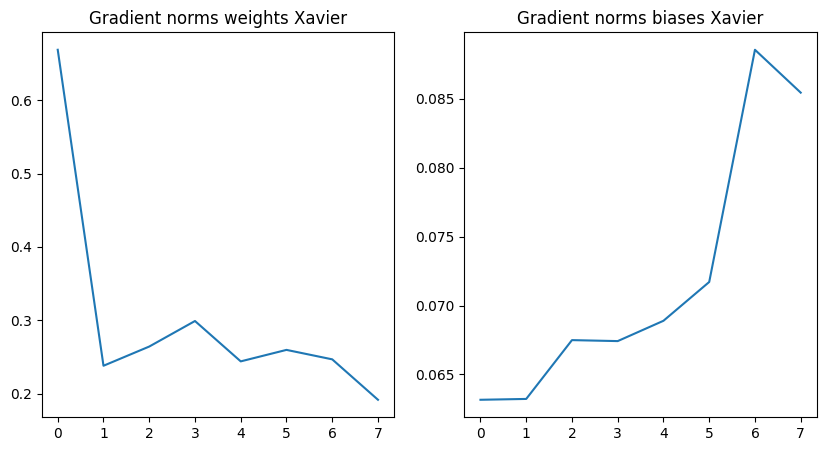

In [13]:
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
train_dataloader = torch.utils.data.DataLoader(training_data,
                                           batch_size=128,
                                           shuffle=True,
                                           drop_last=True)
test_data = datasets.MNIST(
    root = 'data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
test_dataloader = torch.utils.data.DataLoader(test_data,
                                           batch_size=128,
                                           shuffle=True,
                                           drop_last=True)
gradient_norms_w= []
gradient_norms_b = []
initial_values = [0.01, 0.1, 2.0, 'Xavier']
for d in initial_values:
    model = Model(8, d)
    curr_gradient_norms_w = []
    curr_gradient_norms_b = []
    data, target = iter(train_dataloader).next()
    loss = torch.nn.CrossEntropyLoss()
    output = model.forward(data)
    loss = loss(output, target)
    loss.backward()
    # torch.Size([128, 1, 28, 28])
    # torch.Size([128])
    for name, param in model.named_parameters():
        #print(param.grad)
        if param.grad != None:
            with torch.no_grad():
                if name.endswith('weight'): #TODO ask whether norm of bias is also relevant
                    curr_gradient_norms_w.append(param.grad.norm().detach())
                else:
                    curr_gradient_norms_b.append(param.grad.norm().detach())
    gradient_norms_w.append(curr_gradient_norms_w)
    gradient_norms_b.append(curr_gradient_norms_b)
for i in range(4):
    _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    axes[0].plot(gradient_norms_w[i])
    axes[0].title.set_text('Gradient norms weights ' + str(initial_values[i]))
    axes[1].plot(gradient_norms_b[i])
    axes[1].title.set_text('Gradient norms biases ' +str(initial_values[i]))

(d) (8 points) For each of the initialization settings train the model for 5 epochs on
MNIST, using the cross-entropy loss. You may use SGD with learning rate of 0.01
and minibatch sizes of 128. Record the training accuracy and testing accuracy after
each epoch and plot them versus epochs.


0.01
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
0.1
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
2.0
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
Xavier
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4


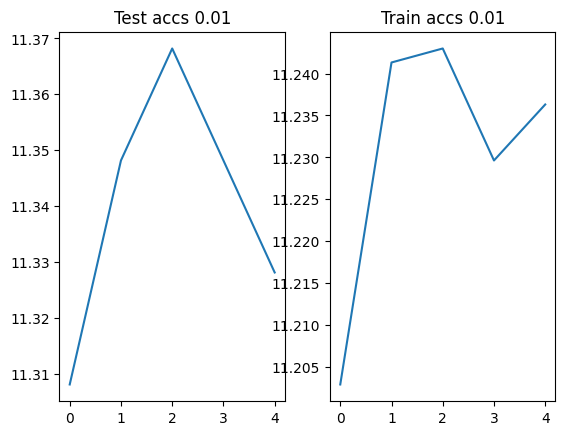

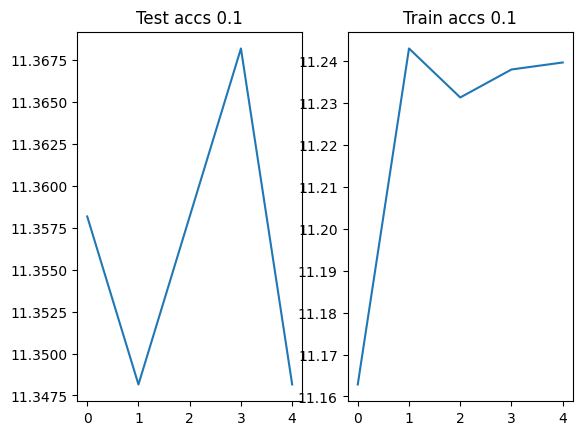

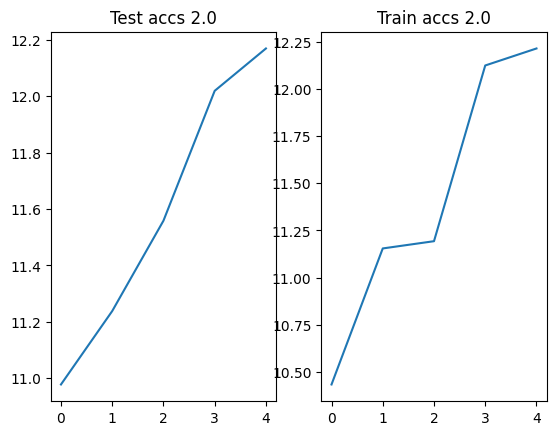

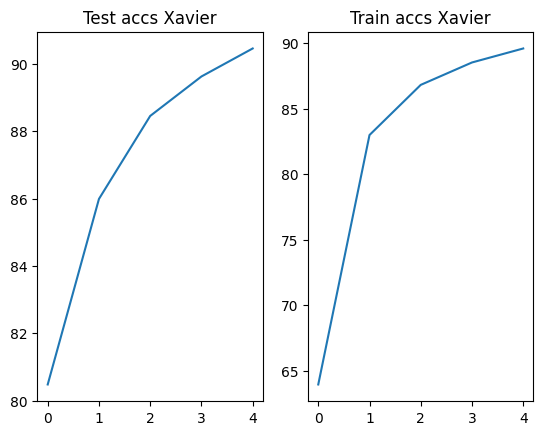

In [3]:
import torch
from matplotlib import pyplot as plt
train_accs = [[], [], [], []]
test_accs = [[], [], [], []]
initial_values = [0.01, 0.1, 2.0, 'Xavier']
for index, i in enumerate(initial_values):
    print(i)
    model = Model(8, i)
    parameter_list = model.parameters()
    optimizer = torch.optim.SGD(parameter_list, lr=0.01)
    loss = torch.nn.CrossEntropyLoss()
    for epoch in range(5):
      print('epoch', epoch)
      epoch_train_acc = [[], [], [], [], []]
      epoch_test_acc= [[], [], [], [], []]
      for data_train, target_train in train_dataloader:
          optimizer.zero_grad()
          output = model.forward(data_train)
          max = torch.argmax(output, dim=1)
          correct = (max == target_train).sum()
          accuracy = 100*correct/target_train.shape[0]
          epoch_train_acc[epoch].append(float(accuracy))
          curr_loss = loss(output, target_train)
          curr_loss.backward()
          optimizer.step()
      for data, target in test_dataloader:
          output = model.forward(data)
          max = torch.argmax(output, dim=1)
          correct = (max == target).sum()
          accuracy = 100*correct/target.shape[0]
          epoch_test_acc[epoch].append(float(accuracy))
      train_accs[index].append(torch.mean(torch.tensor(epoch_train_acc[epoch])))
      test_accs[index].append(torch.mean(torch.tensor(epoch_test_acc[epoch])))
      # print(train_accs)
      # print(test_accs)
for idx, ini in enumerate(initial_values):
    plt.subplot(1, 2, 1)
    plt.plot(test_accs[idx])
    plt.title("Test accs " + str(initial_values[idx]))
    plt.subplot(1, 2, 2)
    plt.plot(train_accs[idx])
    plt.title("Train accs " + str(initial_values[idx]))
    plt.show()


(e) (2 points) Briefly (max 1 paragraph) discuss your findings: how does depth and
initialization affect the activations, gradients, and convergence?
TODO gradient norms and activation

Initialization greatly affects the performance and the convergence of a model. As seen above with a good initialization the model improves faster and starts off with a higher accuracy. With other initialization the model does not improve at all or only really slow.The gradient norms are also greatly affected. Deeper models generalize and perform slightly better with our dataset but need more time to be trained.

3)For the following functions find, by hand, the parameters of a neural network that can
fit these functions. You should use either a 1 or 2 hidden layer network and may use
either sigmoid or ReLU non-linearities. In each case justify your answer and how you
arrived at it (without using numerical tools/software packages).
a)(5 points)
f(x) =
3x when 0 ≤ x ≤ 1/2,
3(1 − x) when 1/2 ≤ x ≤ 1,
0 otherwise

In [14]:
param_dict = {
    'W1' : torch.rand(1,1),
    'W2' : torch.rand(1,1),
    'b1' : torch.rand(1,1),
    'b2' : torch.rand(1,1)
}
data = torch.tensor([0, 1/2, 3/4, 1, 5, 10])
targets = torch.tensor([0, 1.5, 3*(1-3/4), 3*(1-1), 0, 0])
parameter_list = param_dict.values()
optimizer = torch.optim.SGD(parameter_list, lr=0.01)
for i in range(data.shape[0]):
    optimizer.zero_grad()
    output = my_nn(data[i], param_dict)
    curr_loss = torch.mean(torch.abs(output-target[i])) # should we use MSE or absolute error here?
      #curr_loss = torch.mean(torch.square(output-target))
    curr_loss.backward()
    optimizer.step()


NameError: name 'my_nn' is not defined